In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from itertools import cycle
from sklearn import ensemble
import time

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from scipy import interp
import statsmodels.api as sm
from sklearn.metrics import recall_score

from sklearn.model_selection import ShuffleSplit
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_cardio = pd.read_csv('Cardiotocography.csv', sep=',')

df_cardio.head()

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,NSP
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


In [3]:
null_data = df_cardio[df_cardio.isnull().any(axis=1)]
null_data

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,NSP
2126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2127,NaN,NaN,NaN,NaN,0.000,0.000,0.000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2128,NaN,NaN,0.481,0.015,0.015,0.001,0.005,87.0,7.0,91.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df_cardio = df_cardio.dropna()

In [5]:
df_cardio = df_cardio.drop(['Min','Mean','Mode'], axis=1)

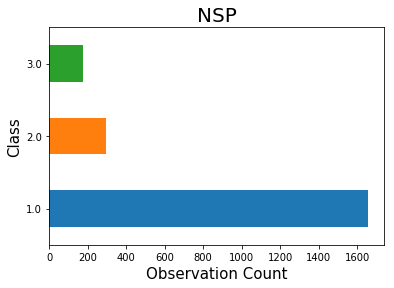

In [6]:
df_cardio['NSP'].value_counts()[:].plot(kind='barh')
plt.title('NSP',fontsize=20)
plt.xlabel('Observation Count',fontsize=15)
plt.ylabel('Class',fontsize=15)
plt.savefig('target__distribution.png')

## Train-Validation Split

In [32]:
y = df_cardio['NSP']
X = df_cardio.drop('NSP',axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 465) 

## Train-Test Split

In [33]:
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train, y_train, test_size = 0.2, random_state = 465) 


## Baseline SVC Model

In [34]:
from sklearn.svm import SVC

start_time = time.time()

svc = SVC()
svc.fit(X_train, y_train)

y_pred_svc = svc.predict(X_test)
print('Accuracy of SVC on test set: {:.3f}\n'.format(svc.score(X_test, y_test)))

print('Cross validation score: {:.4f}\n'.format(cross_val_score(svc, X_test_sub, y_test_sub, cv=20).mean()))

print('Recall score: {}\n'.format(recall_score(y_test, y_pred_svc, average = 'micro')))

print("--- %s seconds ---" % (time.time() - start_time))

Accuracy of SVC on test set: 0.817

Cross validation score: 0.7961

Recall score: 0.8169014084507042

--- 0.5989320278167725 seconds ---


In [45]:
# Binarize the output
y = label_binarize(y, classes=[1, 2, 3])
n_classes = 3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train, y_train, test_size = 0.2, random_state = 465) 

classifier = OneVsRestClassifier(SVC(kernel='linear'))
y_score = classifier.fit(X_train_sub, y_train_sub).decision_function(X_test_sub)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_sub[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

print('Average AUC score: {}'.format((roc_auc[0]+roc_auc[1]+roc_auc[2])/3))

Average AUC score: 0.9446340158365487


## Feature Selection

### SelectKBest: f_classif

In [47]:
from sklearn.feature_selection import SelectKBest, f_classif

y = df_cardio['NSP']
X = df_cardio.drop('NSP',axis=1)

In [88]:
def get_selectKbest_scores(feature_amount):
    score = []
    y = df_cardio['NSP']
    X = df_cardio.drop('NSP',axis=1)
    
    for i in range(1,feature_amount+1):
        
        selector = SelectKBest(f_classif, k = i)

        selector.fit(X, y)

        X_new = selector.transform(X)

        y_new = df_cardio['NSP']

        X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size = 0.2, random_state = 465) 
                   
        X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train, y_train, test_size = 0.2, 
                                                                            random_state = 465) 
                   
        svc = SVC(kernel = 'linear')
        svc.fit(X_train_sub, y_train_sub)
        
        score.append(cross_val_score(svc, X_test, y_test, cv=20).mean())
        
    #return score
    plt.figure(figsize=(12, 6)) #visualize mean prediction errors in relation to k number
    plt.plot(range(1,feature_amount+1), score, color='blue', linestyle='dashed', marker='o',  
    markerfacecolor='blue', markersize=10)    
    plt.title('Score vs Best Feature Count')  
    plt.xlabel('Feature Count')  
    plt.ylabel('Score')
    

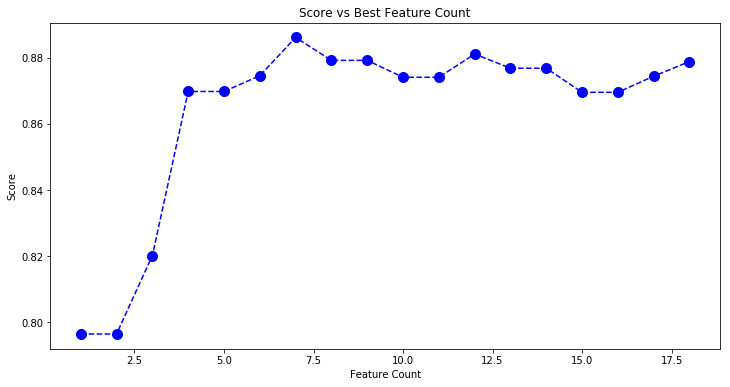

In [89]:
get_selectKbest_scores(18)

In [48]:
selector = SelectKBest(f_classif, k=7)

selector.fit(X, y)

X_new = selector.transform(X)

X_new.shape
print("feature indices: {}\n".format(selector.get_support(indices=True)))

y = df_cardio['NSP']

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size = 0.2, random_state = 465) 
                   
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train, y_train, test_size = 0.2, random_state = 465) 
                   
svc = SVC(kernel= 'linear')
svc.fit(X_train_sub, y_train_sub)

y_pred_svc = svc.predict(X_test)
print('Accuracy of SVC on test set: {:.3f}\n'.format(svc.score(X_test, y_test)))

print(cross_val_score(svc, X_test, y_test, cv=20).mean())

feature indices: [ 0  1  6  7  9 15 16]

Accuracy of SVC on test set: 0.873

0.8861471861471862


In [49]:
# Binarize the output
y = label_binarize(y, classes=[1, 2, 3])
n_classes = 3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train, y_train, test_size = 0.2, random_state = 465) 

classifier = OneVsRestClassifier(SVC(kernel='linear'))
y_score = classifier.fit(X_train_sub, y_train_sub).decision_function(X_test_sub)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_sub[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

print('Average AUC score: {}'.format((roc_auc[0]+roc_auc[1]+roc_auc[2])/3))

Average AUC score: 0.9432312232230298


### L1 Based Feature Elimination

In [223]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

y = df_cardio['NSP']
X = df_cardio.drop('NSP',axis=1)

In [224]:
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X)

print("feature indices: {}\n".format(model.get_support(indices=True)))

feature indices: [ 0  7  8  9 10 11 12 13 15 16]



In [50]:
y = df_cardio['NSP']
X = df_cardio[['LB','ASTV','MSTV','ALTV','MLTV','Width','Max','Nmax','Median','Variance']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 465) 
                   
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train, y_train, test_size = 0.2, random_state = 465) 

svc = SVC(kernel='linear')
svc.fit(X_train_sub, y_train_sub)

y_pred_svc = svc.predict(X_test)
print('Accuracy of SVC classifier on test set: {:.3f}\n'.format(svc.score(X_test, y_test)))

print(cross_val_score(svc, X_test, y_test, cv=20).mean())


Accuracy of SVC classifier on test set: 0.883

0.8814593301435407


In [51]:
# Binarize the output
y = label_binarize(y, classes=[1, 2, 3])
n_classes = 3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train, y_train, test_size = 0.2, random_state = 465) 

classifier = OneVsRestClassifier(SVC(kernel='linear'))
y_score = classifier.fit(X_train_sub, y_train_sub).decision_function(X_test_sub)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_sub[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

print('Average AUC score: {}'.format((roc_auc[0]+roc_auc[1]+roc_auc[2])/3))

Average AUC score: 0.9446340158365487


### L2 Based Feature Elimination

In [226]:
y = df_cardio['NSP']
X = df_cardio.drop('NSP',axis=1)

In [227]:
lsvc = LinearSVC(C=0.01, penalty="l2", dual=False).fit(X, y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X)

print("feature indices: {}\n".format(model.get_support(indices=True)))

feature indices: [ 0  2  8 15 17]



In [52]:
y = df_cardio['NSP']
X = df_cardio[['LB','FM','MSTV','Median','Tendency']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 465) 
                   
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train, y_train, test_size = 0.2, random_state = 465) 

svc = SVC(kernel='linear')
svc.fit(X_train_sub, y_train_sub)

y_pred_svc = svc.predict(X_test)
print('Accuracy of SVC on test set: {:.3f}\n'.format(svc.score(X_test, y_test)))

print(cross_val_score(svc, X_test, y_test, cv=20).mean())

Accuracy of SVC on test set: 0.838

0.8039359763043974


In [53]:
# Binarize the output
y = label_binarize(y, classes=[1, 2, 3])
n_classes = 3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train, y_train, test_size = 0.2, random_state = 465) 

classifier = OneVsRestClassifier(SVC(kernel='linear'))
y_score = classifier.fit(X_train_sub, y_train_sub).decision_function(X_test_sub)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_sub[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

print('Average AUC score: {}'.format((roc_auc[0]+roc_auc[1]+roc_auc[2])/3))


Average AUC score: 0.9068475210749254


## Final SVC Model

In [54]:
y = df_cardio['NSP']

#X = df_cardio[['LB','AC','DP','ASTV','ALTV','Median','Variance']] #selectkbest

X = df_cardio[['LB','ASTV','MSTV','ALTV','MLTV','Width','Max','Nmax','Median','Variance']] #L1

#X = df_cardio[['LB','FM','MSTV','Median','Tendency']] #L2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 465) 
                   
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train, y_train, test_size = 0.2, random_state = 465) 

start_time = time.time()

svc = SVC(kernel='linear')
svc.fit(X_train_sub, y_train_sub)

predict_train_svc = svc.predict(X_train)
predict_test_svc = svc.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train_svc, margins=True)
table_test = pd.crosstab(y_test, predict_test_svc, margins=True)

y_pred_svc = svc.predict(X_test)
print('Accuracy of SVC on test set: {:.3f}\n'.format(svc.score(X_test, y_test)))

print('Cross validation score: {:.4f}\n'.format(cross_val_score(svc, X_test_sub, y_test_sub, cv=20).mean()))

print('Recall score: {}\n'.format(recall_score(y_test, y_pred_svc, average = 'micro')))

print("--- %s seconds ---" % (time.time() - start_time))

Accuracy of SVC on test set: 0.883

Cross validation score: 0.8625

Recall score: 0.8826291079812206

--- 3.7035071849823 seconds ---


In [219]:
print(np.unique(y_pred_svc))

[1. 2. 3.]


In [220]:
print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

         1.0       0.94      0.95      0.94       339
         2.0       0.53      0.58      0.55        48
         3.0       0.89      0.64      0.75        39

    accuracy                           0.88       426
   macro avg       0.79      0.73      0.75       426
weighted avg       0.89      0.88      0.88       426



- The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier to not label a sample as positive if it is negative.
- The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.
- The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.
- The F-beta score weights the recall more than the precision by a factor of beta. beta = 1.0 means recall and precision are equally important.
- The support is the number of occurrences of each class in y_test.

In [221]:
# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train_svc, margins=True)
table_test = pd.crosstab(y_test, predict_test_svc, margins=True)

train_tI_errors = ((1-(table_train.loc[1.0,1.0]/table_train.loc['All',1.0]))
                   +(1-(table_train.loc[2.0,2.0]/table_train.loc['All',2.0]))
                   +(1-(table_train.loc[3.0,3.0]/table_train.loc['All',3.0])))/3 

train_tII_errors = ((1-(table_train.loc[1.0,1.0]/table_train.loc[1.0,'All']))
                   +(1-(table_train.loc[2.0,2.0]/table_train.loc[2.0,'All']))
                   +(1-(table_train.loc[3.0,3.0]/table_train.loc[3.0,'All'])))/3 

test_tI_errors = ((1-(table_test.loc[1.0,1.0]/table_test.loc['All',1.0]))
                   +(1-(table_test.loc[2.0,2.0]/table_test.loc['All',2.0]))
                   +(1-(table_test.loc[3.0,3.0]/table_test.loc['All',3.0])))/3 

test_tII_errors = ((1-(table_test.loc[1.0,1.0]/table_test.loc[1.0,'All']))
                   +(1-(table_test.loc[2.0,2.0]/table_test.loc[2.0,'All']))
                   +(1-(table_test.loc[3.0,3.0]/table_test.loc[3.0,'All'])))/3 
print((
    'Training set accuracy:\n'
    'AVG Percent Type I errors: {}\n'
    'AVG Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'AVG Percent Type I errors: {}\n'
    'AVG Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
AVG Percent Type I errors: 0.18121556655086501
AVG Percent Type II errors: 0.20805058239156374

Test set accuracy:
AVG Percent Type I errors: 0.21420302876414443
AVG Percent Type II errors: 0.27427955525300657


In [222]:
print((
    'Accuracy Differentials:\n'
    'Type I error difference: {}\n\n'
    'Type II error difference: {}\n'
).format(test_tI_errors - train_tI_errors, test_tII_errors - train_tII_errors))

Accuracy Differentials:
Type I error difference: 0.03298746221327942

Type II error difference: 0.06622897286144283



## ROC Curve

In [40]:
y = df_cardio['NSP']

#X = df_cardio[['LB','AC','DP','ASTV','ALTV','Median','Variance']] #selectkbest

X = df_cardio[['LB','ASTV','MSTV','ALTV','MLTV','Width','Max','Nmax','Median','Variance']] #L1

#X = df_cardio[['LB','FM','MSTV','Median','Tendency']] #L2


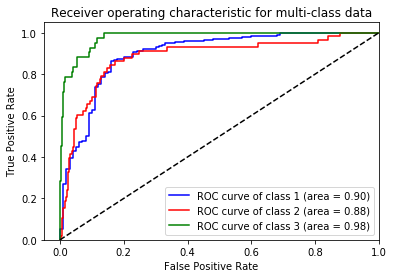

In [41]:
# Binarize the output
y = label_binarize(y, classes=[1, 2, 3])
n_classes = 3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

classifier = OneVsRestClassifier(SVC(kernel='linear'))
y_score = classifier.fit(X, y).decision_function(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i+1, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.savefig('ROC_SVC.png')
plt.show()

In [96]:
print(np.unique(y_pred_svc))

[1. 2. 3.]
